In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [ ]:
! pip install iterative-stratification

In [ ]:
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 15, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [ ]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

In [ ]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [ ]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [ ]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [ ]:
train.shape, test.shape

In [ ]:
train = train.values
target = target.values
test = test.values

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

## Train test split for testing 

In [ ]:
y1 = torch.tensor([-4.,1.,5.,0.])
y2 = torch.tensor([1.,0.,1.,0.])
nn.BCEWithLogitsLoss()(y1,y2)

In [472]:
def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

In [347]:


full_dataset = TrainDataset(train, target, noise = False)

train_size = int(0.9* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 512, shuffle = False)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

155 batches 
5  batches 


# Model 1 

In [454]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [455]:
model_filenames = []
val_losses = []

# Model 1 training 

In [456]:
num_epochs = 45 ## changes here 

model = Model()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1, ## wooo hoo
                                                 patience=7, ## was 3 for 158 
                                                 eps=1e-4, 
                                                 verbose=True)


criterion = nn.BCEWithLogitsLoss()

val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1)

val_losses.append(val_loss)
model_filenames.append(filename)
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.020748450234532357    >saving model as:  ./model_1.pth
epoch  2  out of  45      > Val loss decreased from: 0.020748450234532357  to  0.019001370295882225    >saving model as:  ./model_1.pth
epoch  3  out of  45      > Val loss decreased from: 0.019001370295882225  to  0.01833629608154297    >saving model as:  ./model_1.pth
epoch  4  out of  45      > Val loss decreased from: 0.01833629608154297  to  0.017614253237843512    >saving model as:  ./model_1.pth
epoch  5  out of  45      > Val loss decreased from: 0.017614253237843512  to  0.017354720458388328    >saving model as:  ./model_1.pth
epoch  6  out of  45      > Val loss decreased from: 0.017354720458388328  to  0.01735384836792946    >saving model as:  ./model_1.pth
epoch  7  out of  45      > Val loss decreased from: 0.01735384836792946  to  0.017228595912456512    >saving model as:  ./model_1.pth
epoch  8  out of  45      > Val loss decreased from: 0.0172285959

# Model 2 

In [457]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 512))
        
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(512, 206))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.dense4(x)
        
        return x

# Model 2 training

In [458]:
num_epochs = 45 ## changes here 

model = Model_2()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1, ## wooo hoo
                                                 patience=7, ## was 3 for 158 
                                                 eps=1e-4, 
                                                 verbose=True)


criterion = nn.BCEWithLogitsLoss()

val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100)


val_losses.append(val_loss)
model_filenames.append(filename)
    
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.020921602472662927    >saving model as:  ./model_100.pth
epoch  2  out of  45      > Val loss decreased from: 0.020921602472662927  to  0.019058291241526602    >saving model as:  ./model_100.pth
epoch  3  out of  45      > Val loss decreased from: 0.019058291241526602  to  0.01854160465300083    >saving model as:  ./model_100.pth
epoch  4  out of  45      > Val loss decreased from: 0.01854160465300083  to  0.017702825367450714    >saving model as:  ./model_100.pth
epoch  5  out of  45      > Val loss decreased from: 0.017702825367450714  to  0.017415288463234903    >saving model as:  ./model_100.pth
epoch  6  out of  45      > Val loss decreased from: 0.017415288463234903  to  0.017212071269750596    >saving model as:  ./model_100.pth
epoch  7  out of  45      > Val loss decreased from: 0.017212071269750596  to  0.017006976157426835    >saving model as:  ./model_100.pth
epoch  8  out of  45      > Val loss decreased fr

In [459]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,model_filenames, device = device):
        super(blend, self).__init__()
        print("loading models...")
        self.model_filenames = model_filenames
        self.model_list = model_list
        self.weights = weights 

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)
            self.model_list[i].eval()
            
        print("done loading from", self.model_filenames)

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()

In [475]:
weights = create_weights_from_val_losses(np.array(val_losses))
bb = blend(
    weights = weights, 
    model_list = [Model(), Model_2()],
    model_filenames = model_filenames
)

loading models...
done loading from ['./model_1.pth', './model_100.pth']


In [461]:
model_filenames

['./model_1.pth', './model_100.pth']

In [473]:
all_models = [Model(), Model_2()]
test_val_losses = {}

for i in range(len(model_filenames)):
    all_models[i].load_state_dict(torch.load(model_filenames[i]))
    all_models[i].to(device)
    all_models[i].eval()
    
all_val_losses = []

with torch.no_grad():
    for i in range(len(all_models)):
        val_loss = validate_fn(all_models[i], val_loader, criterion, device)
        test_val_losses["model_" + str(i+1)] = val_loss
    print("done validating")

test_val_losses

done validating


{'model_1': 0.015921371430158614, 'model_2': 0.01604318991303444}

In [476]:
val_loss = validate_fn(bb, val_loader, criterion, device)
test_val_losses["model_blend"] = val_loss
test_val_losses

{'model_1': 0.015921371430158614,
 'model_2': 0.01604318991303444,
 'model_blend': 0.015878767147660254}

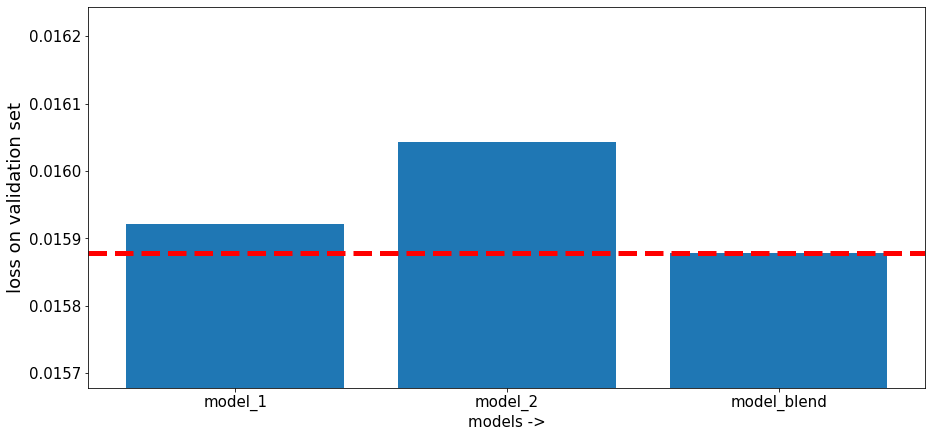

In [477]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

plt.bar(names, vals)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("loss on validation set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()

In [478]:
min(vals)

0.015878767147660254